<a href="https://colab.research.google.com/github/adong-hood/dm-24/blob/main/module_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 8: Cluster Analysis

The following tutorial contains Python examples for solving clustering problems. You should refer to Chapters 7 and 8 of the "Introduction to Data Mining" book to understand some of the concepts introduced in this tutorial. The notebook can be downloaded from http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial8/tutorial8.ipynb.

Cluster analysis seeks to partition the input data into groups of closely related instances so that instances that belong to the same cluster are more similar to each other than to instances that belong to other clusters. In this tutorial, we will provide examples of using different clustering techniques provided by the scikit-learn library package.

Read the step-by-step instructions below carefully. To execute the code, click on the corresponding cell and press the SHIFT-ENTER keys simultaneously.


In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN, k_means, KMeans
from sklearn.preprocessing import StandardScaler, normalize


## 8.1 K-means Clustering

The k-means clustering algorithm represents each cluster by its corresponding cluster centroid. The algorithm would partition the input data into *k* disjoint clusters by iteratively applying the following two steps:
1. Form *k* clusters by assigning each instance to its nearest centroid.
2. Recompute the centroid of each cluster.

In this section, we perform k-means clustering on a toy example of movie ratings dataset. We first create the dataset as follows.

In [ ]:
ratings = [['john',5,5,2,1],['mary',4,5,3,2],['bob',4,4,4,3],['lisa',2,2,4,5],['lee',1,2,3,4],['harry',2,1,5,5]]
titles = ['user','Jaws','Star Wars','Exorcist','Omen']
movies = pd.DataFrame(ratings,columns=titles)
movies

,user,Jaws,Star Wars,Exorcist,Omen
0,john,5,5,2,1
1,mary,4,5,3,2
2,bob,4,4,4,3
3,lisa,2,2,4,5
4,lee,1,2,3,4
5,harry,2,1,5,5


In this example dataset, the first 3 users liked action movies (Jaws and Star Wars) while the last 3 users enjoyed horror movies (Exorcist and Omen). Our goal is to apply k-means clustering on the users to identify groups of users with similar movie preferences.

The example below shows how to apply k-means clustering (with k=2) on the movie ratings data. We must remove the "user" column first before applying the clustering algorithm. The cluster assignment for each user is displayed as a dataframe object.

In [ ]:


data = movies.drop('user',axis=1)
k_means = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
k_means.fit(data)
labels = k_means.labels_
pd.DataFrame(labels, index=movies.user, columns=['Cluster ID'])

,Cluster ID
user,
john,0
mary,0
bob,0
lisa,1
lee,1
harry,1


The k-means clustering algorithm assigns the first three users to one cluster and the last three users to the second cluster. The results are consistent with our expectation. We can also display the centroid for each of the two clusters.

In [ ]:
centroids = k_means.cluster_centers_
pd.DataFrame(centroids,columns=data.columns)

,Jaws,Star Wars,Exorcist,Omen
0,4.333333,4.666667,3.0,2.000000
1,1.666667,1.666667,4.0,4.666667


Observe that cluster 0 has higher ratings for the horror movies whereas cluster 1 has higher ratings for action movies. The cluster centroids can be applied to other users to determine their cluster assignments.

In [ ]:

testData = np.array([[4,5,1,2],[3,2,4,4],[2,3,4,1],[3,2,3,3],[5,4,1,4]])
labels = k_means.predict(testData)
labels = labels.reshape(-1,1)
usernames = np.array(['paul','kim','liz','tom','bill']).reshape(-1,1)
cols = movies.columns.tolist()
cols.append('Cluster ID')
newusers = pd.DataFrame(np.concatenate((usernames, testData, labels), axis=1),columns=cols)
newusers

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,user,Jaws,Star Wars,Exorcist,Omen,Cluster ID
0,paul,4,5,1,2,0
1,kim,3,2,4,4,1
2,liz,2,3,4,1,0
3,tom,3,2,3,3,1
4,bill,5,4,1,4,0


To determine the number of clusters in the data, we can apply k-means with varying number of clusters from 1 to 6 and compute their corresponding sum-of-squared errors (SSE) as shown in the example below. The "elbow" in the plot of SSE versus number of clusters can be used to estimate the number of clusters.

Text(0, 0.5, 'SSE')

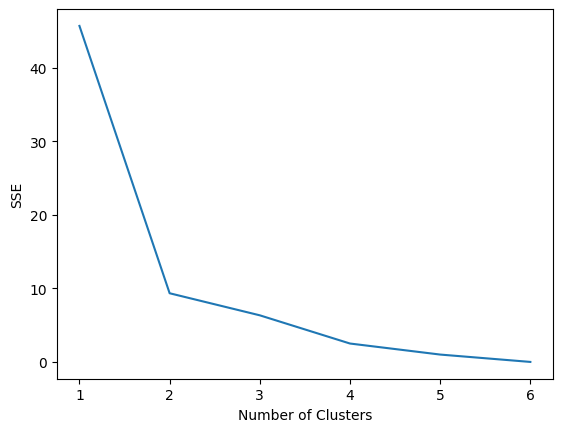

In [ ]:

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(data)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

## 8.2 Hierarchical Clustering

This section demonstrates examples of applying hierarchical clustering to the vertebrate dataset used in Module 6 (Classification). Specifically, we illustrate the results of using 3 hierarchical clustering algorithms provided by the Python scipy library: (1) single link (MIN), (2) complete link (MAX), and (3) group average. Other hierarchical clustering algorithms provided by the library include centroid-based and Ward's method.

In [ ]:
data = pd.read_csv('http://pluto.hood.edu/~dong/datasets/vertebrate.csv',header='infer')
data

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians
5,komodo,0,0,0,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,birds
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,fishes


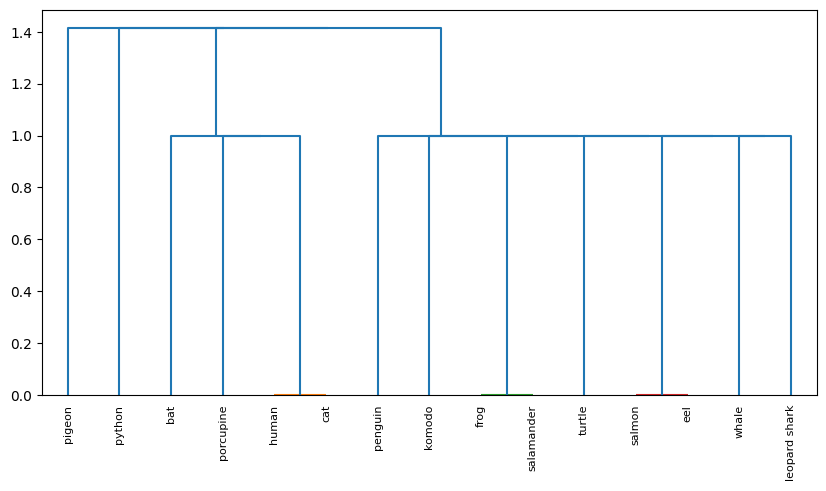

In [ ]:
names = data['Name']
Y = data['Class']
X = data.drop(['Name','Class'],axis=1)
Z = hierarchy.linkage(X, 'single')
#dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

plt.figure(figsize=(10, 5))  # Adjust the width and height
dn = hierarchy.dendrogram(Z,labels=names.tolist(),  leaf_font_size=8)
plt.xticks(rotation=90)
plt.show()

### 8.2.2 Complete Link (MAX)

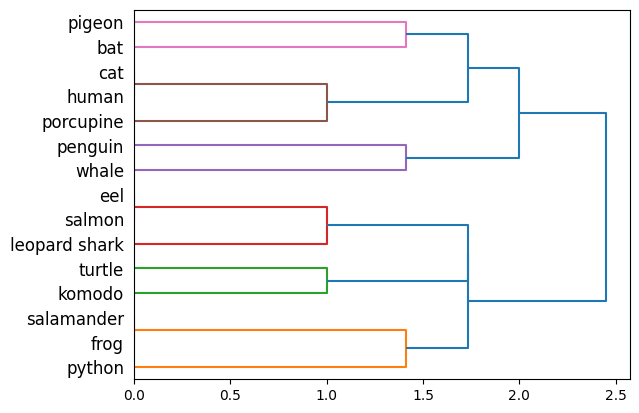

In [ ]:
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

### 8.3.3 Group Average

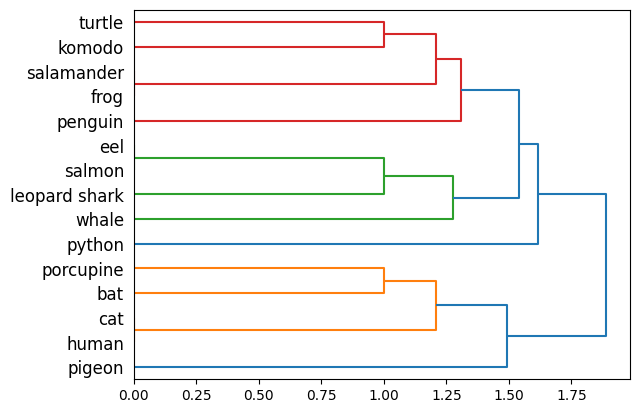

In [ ]:
Z = hierarchy.linkage(X, 'average')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

## 8.3 Density-Based Clustering

Density-based clustering identifies the individual clusters as high-density regions that are separated by regions of low density. DBScan is one of the most popular density based clustering algorithms. In DBScan, data points are classified into 3 types---core points, border points, and noise points---based on the density of their local neighborhood. The local neighborhood density is defined according to 2 parameters:  radius of neighborhood size (eps) and minimum number of points in the neighborhood (min_samples).

For this approach, we will use a noisy, 2-dimensional dataset originally created by Karypis et al. [1] for evaluating their proposed CHAMELEON algorithm. The example code shown below will load and plot the distribution of the data.

<Axes: xlabel='x', ylabel='y'>

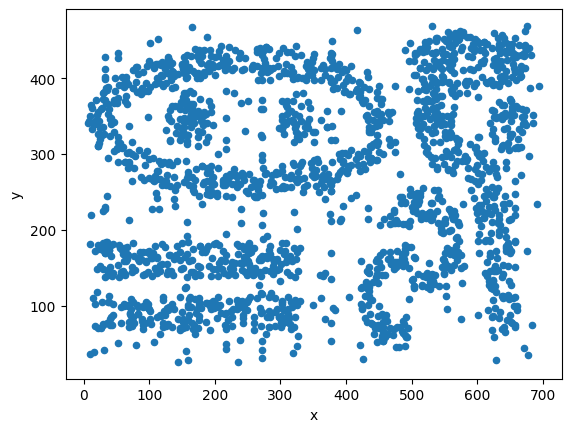

In [ ]:
data = pd.read_csv('http://pluto.hood.edu/~dong/datasets/chameleon.data', delimiter=' ', names=['x','y'])
data.plot.scatter(x='x',y='y')

We apply the DBScan clustering algorithm on the data by setting the neighborhood radius (eps) to 15.5 and minimum number of points (min_samples) to be 5. The clusters are assigned to IDs between 0 to 8 while the noise points are assigned to a cluster ID equals to -1.

In [ ]:
result['Cluster ID'].value_counts()

,count
Cluster ID,
3,560
4,450
0,229
5,203
1,127
-1,125
2,109
7,72
6,55


(1971, 2)


<Axes: xlabel='x', ylabel='y'>

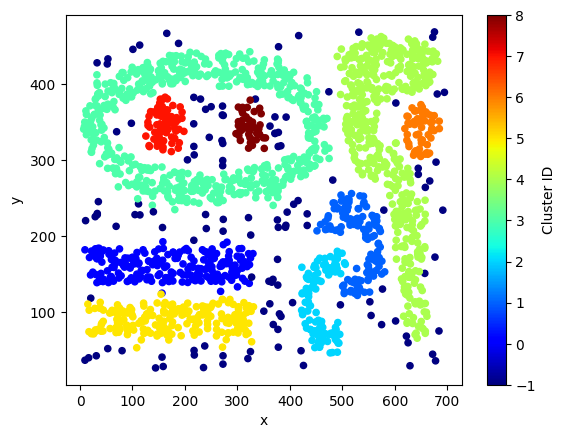

In [ ]:
print(data.shape)
db = DBSCAN(eps=15.5, min_samples=5).fit(data)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#print(len(core_samples_mask[core_samples_mask == True]))

labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])
result = pd.concat((data,labels), axis=1)
result.plot.scatter(x='x',y='y',c='Cluster ID', colormap='jet')


## 8.4 Spectral Clustering

One of the main limitations of the k-means clustering algorithm is its tendency to seek for globular-shaped clusters. Thus, it does not work when applied to datasets with arbitrary-shaped clusters or when the cluster centroids overlapped with one another. Spectral clustering can overcome this limitation by exploiting properties of the similarity graph to overcome such limitations. To illustrate this, consider the following two-dimensional datasets.

<Axes: xlabel='x', ylabel='y'>

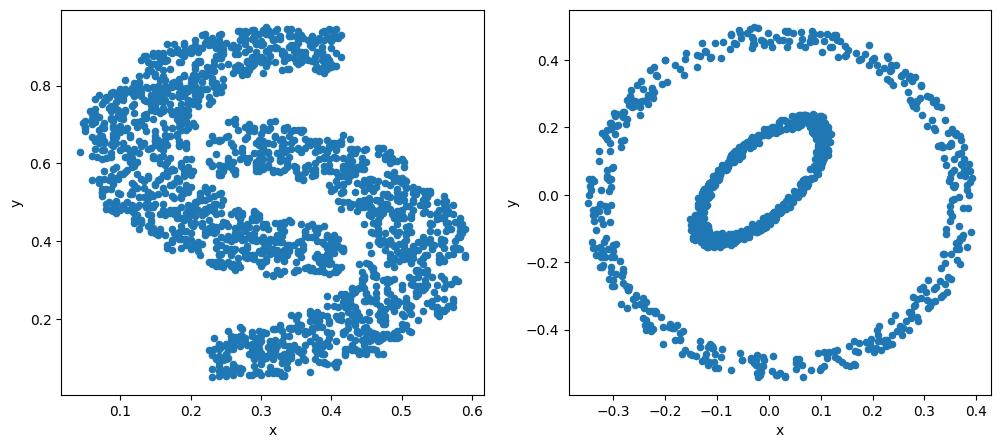

In [ ]:
import pandas as pd

data1 = pd.read_csv('http://pluto.hood.edu/~dong/datasets/2d_data.txt', delimiter=' ', names=['x','y'])
data2 = pd.read_csv('http://pluto.hood.edu/~dong/datasets/elliptical.txt', delimiter=' ', names=['x','y'])

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
data1.plot.scatter(x='x',y='y',ax=ax1)
data2.plot.scatter(x='x',y='y',ax=ax2)

Below, we demonstrate the results of applying k-means to the datasets (with k=2).

Text(0.5, 1.0, 'K-means Clustering')

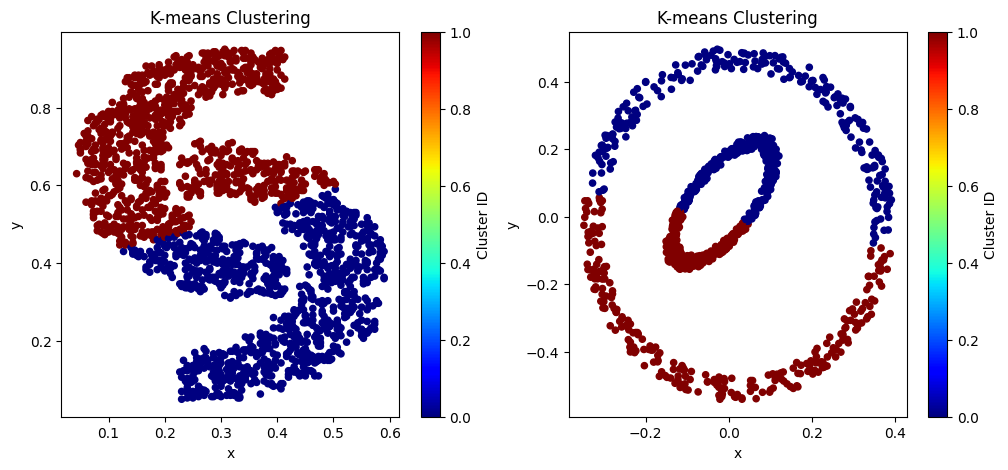

In [ ]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1, n_init = 'auto')
k_means.fit(data1)
labels1 = pd.DataFrame(k_means.labels_,columns=['Cluster ID'])
result1 = pd.concat((data1,labels1), axis=1)

k_means2 = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1,  n_init = 'auto')
k_means2.fit(data2)
labels2 = pd.DataFrame(k_means2.labels_,columns=['Cluster ID'])
result2 = pd.concat((data2,labels2), axis=1)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
result1.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax1)
ax1.set_title('K-means Clustering')
result2.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax2)
ax2.set_title('K-means Clustering')

The plots above show the poor performance of k-means clustering. Next, we apply spectral clustering to the datasets. Spectral clustering converts the data into a similarity graph and applies the normalized cut graph partitioning algorithm to generate the clusters. In the example below, we use the Gaussian radial basis function as our affinity (similarity) measure. Users need to tune the kernel parameter (gamma) value in order to obtain the appropriate clusters for the given dataset.

Text(0.5, 1.0, 'Spectral Clustering')

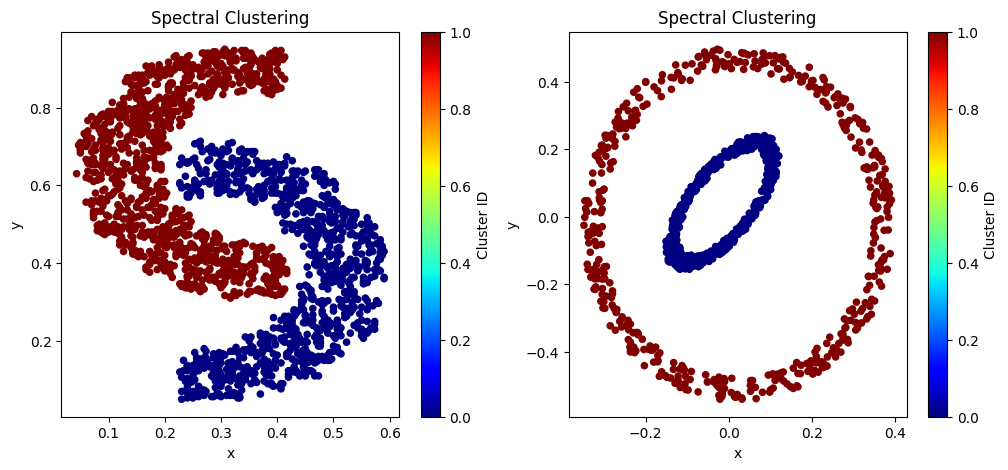

In [ ]:
from sklearn import cluster
import pandas as pd

spectral = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=5000)
spectral.fit(data1)
labels1 = pd.DataFrame(spectral.labels_,columns=['Cluster ID'])
result1 = pd.concat((data1,labels1), axis=1)

spectral2 = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=1000)
spectral2.fit(data2)
labels2 = pd.DataFrame(spectral2.labels_,columns=['Cluster ID'])
result2 = pd.concat((data2,labels2), axis=1)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
result1.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax1)
ax1.set_title('Spectral Clustering')
result2.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax2)
ax2.set_title('Spectral Clustering')

## 8.5 Summary

This tutorial illustrates examples of using different Python's implementation of clustering algorithms. Algorithms such as k-means, spectral clustering, and DBScan are designed to create disjoint partitions of the data whereas the single-link, complete-link, and group average algorithms are designed to generate a hierarchy of cluster partitions.

References:
[1] George Karypis, Eui-Hong Han, and Vipin Kumar. CHAMELEON: A Hierarchical Clustering Algorithm Using Dynamic Modeling. IEEE Computer 32(8): 68-75, 1999.

## Homework 5 ##



1. Given the file college-and-university.csv, conduct K-means clustering analysis based on Median SAT, Acceptance Rate, Expenditures/Student, Top 10% HS, and Graduation %. Do not use Type and School in your analysis. Determine the optimal value of K.

2. Using college-and-university.csv, conduct Hierarchical clustering analysis based on Median SAT, Acceptance Rate, Expenditures/Student, Top 10% HS, and Graduation %. Do not use Type and School in your analysis. **Show at least two hierarchical algorithms. Compare and contrast the results.**

3. Using the data in df below, conduct K-means and density-based clustering. Provide visualizations of the clustering results. Use eps=30 and min_samples=6 for DBScan. **You are encouraged to experiment with eps and min_samples to optimize the results.**

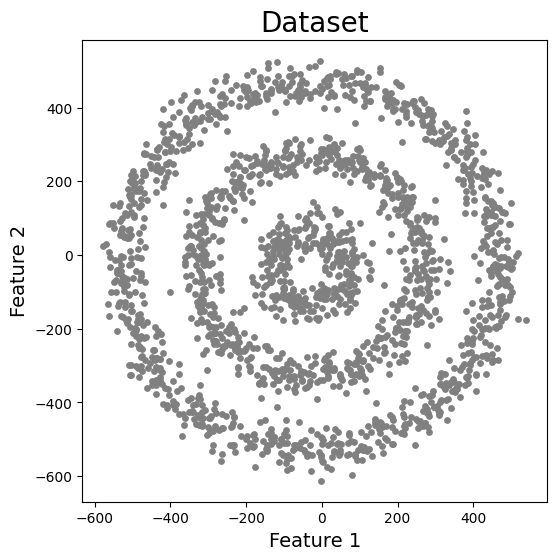

In [ ]:
np.random.seed(42)

# Function for creating datapoints in the form of a circle
def PointsInCircum(r,n=100):
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-30,30),math.sin(2*math.pi/n*x)*r+np.random.normal(-30,30)) for x in range(1,n+1)]

# Creating data points in the form of a circle
df1 = pd.DataFrame(PointsInCircum(500,1000))
df2 = pd.DataFrame(PointsInCircum(300,700))
df3 = pd.DataFrame(PointsInCircum(100,300))

# Adding noise to the dataset
df4 = pd.DataFrame([(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)])

#df = pd.concat([df1, df2, df3, df4], axis= 0)
df = pd.concat([df1, df2, df3], axis= 0)

plt.figure(figsize=(6,6))
plt.scatter(df[0],df[1],s=15,color='grey')
plt.title('Dataset',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

4. Using the data in the DataFrame df above, conduct spectral clustering and provide a visualization of the clustering results. Be sure to scale your data first.

5. Given the results from questions 4 and 5, evaluate the performance of K-means, DBSCAN, and spectral clustering **quantitatively**.